In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from tqdm import tqdm

In [2]:
from plots import plot_learning_history_with_pgs

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [4]:
cuda = torch.cuda.is_available()

In [5]:
cuda = torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor   if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor   if use_cuda else torch.ByteTensor


def convert_to_var(arr, astype='float32', add_dim=False):
    cuda = torch.cuda.is_available()
    use_cuda = torch.cuda.is_available()
    FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
    LongTensor = torch.cuda.LongTensor   if use_cuda else torch.LongTensor
    ByteTensor = torch.cuda.ByteTensor   if use_cuda else torch.ByteTensor
    if add_dim:
        arr = np.array([arr])
    if astype == 'float32':
        v = Variable(FloatTensor(arr.astype(astype))) 
    else:
        v = Variable(LongTensor(arr.astype(astype)))
    return v

In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [7]:
class VAE(nn.Module):
    def __init__(self, input_shape=(-1, 10),
                 latent_dim=2, n_samples=10,
                 fc_size=1024, num_layers=2):
        super(VAE, self).__init__()
        self.n_samples = n_samples
        self.input_shape = input_shape
        
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_shape[-1], fc_size))
        encoder_layers.append(nn.ReLU())
        for i in range(1,num_layers):
            encoder_layers.append(nn.Linear(fc_size//2**(i-1), fc_size//2**i))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
            
        self.fc_mu = nn.Linear(fc_size//2**(num_layers-1), latent_dim)
        self.fc_logvar = nn.Linear(fc_size//2**(num_layers-1), latent_dim)
        
        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_dim, fc_size//2**(num_layers-1)))
        decoder_layers.append(nn.ReLU())
        
        for i in range(num_layers-1):
            decoder_layers.append(nn.Linear(fc_size//2**(num_layers-1-i), fc_size//2**(num_layers-i-2)))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(fc_size, 2*input_shape[1]))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        enc_out = self.encoder(x)
        return self.fc_mu(enc_out), self.fc_logvar(enc_out)

    def reparameterize(self, mu, logvar):
        if self.training:
            n_samples = self.n_samples
            batch_size = mu.shape[0]
            latent_dim = mu.shape[1]
            eps = np.random.randn(batch_size*latent_dim*n_samples)\
                                 .reshape((batch_size, n_samples, latent_dim))
            eps = convert_to_var(eps)
            std = logvar.mul(0.5).exp_()
            mu = mu.view(-1, 1, latent_dim)
            std = std.view(-1, 1, latent_dim)
            return mu + eps*std
        else:
            return mu

    def decode(self, z):
        dec_out = self.decoder(z)
        if len(dec_out.shape) == 3:
            dec_out = dec_out.view(-1, self.n_samples, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)
            recon_x = probs[:,:,:,1]
        else:
            dec_out = self.decoder(z)
            dec_out = dec_out.view(-1, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)   
            recon_x = probs[:,:,1]
        return recon_x, log_probs

    
    def forward(self, x):
        mu, logvar = self.encode(x.view(self.input_shape))
        z = self.reparameterize(mu, logvar)
        recon_x, log_probs = self.decode(z)
        return recon_x, log_probs, mu, logvar

In [8]:
def loss_function(log_probs, x, mu, logvar, kl_weight=1, n_samples=10):
    KLD = 0.5 * torch.mean(
                      torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar, dim=1))
    
    if len(log_probs.shape)==4:
        x = x.view(-1, 1, x.shape[1]).clone()
        x = x.repeat(1, n_samples, 1)
        LL = torch.sum((1-x)*log_probs[:,:,:,0] + x * log_probs[:,:,:,1]) / (x.shape[0]*n_samples)
    else:
        LL = torch.sum((1-x)*log_probs[:,:,0] + x * log_probs[:,:,1]) / (x.shape[0])

    elbo = LL - kl_weight * KLD
    loss = -1 * elbo
    return  loss, LL, KLD

In [9]:
from IPython.display import clear_output
from tqdm import trange

# функция для итераций по минибатчам, из первого семинара
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [17]:
def get_obj_log_prob(model, obj, kl_weight=1, return_loss=False):
    x = np.array([obj])
    probs, log_probs, mu, logvar = model(convert_to_var(x))
    
    if return_loss:
        loss, ll, kld = loss_function(log_probs, convert_to_var(x), mu, logvar,
                                      kl_weight=kl_weight, n_samples=model.n_samples)

    log_probs = log_probs.data.numpy()[0].mean(axis=0)
    log_probs = log_probs[np.arange(dim), obj.astype('int64')]
    obj_log_prob = log_probs.sum()

    if return_loss:
        return obj_log_prob, loss, ll, kld
    else:
        return obj_log_prob

In [18]:
dim = 50
num_classes = 5

In [19]:
def get_one_hot_object(obj_class, dim, num_classes):
    x = np.zeros(dim)
    x[:(dim//num_classes) * (obj_class+1)] = 1
    return x

# Онлайн-обучение

### Стационарные данные

In [24]:
def get_obj_log_prob(model, obj, kl_weight=1, return_loss=False):
    x = np.array([obj])
    probs, log_probs, mu, logvar = model(convert_to_var(x))
    
    if return_loss:
        loss, ll, kld = loss_function(log_probs, convert_to_var(x), mu, logvar,
                                      kl_weight=kl_weight, n_samples=model.n_samples)

    log_probs = log_probs.data.numpy()[0].mean(axis=0)
    log_probs = log_probs[np.arange(dim), obj.astype('int64')]
    obj_log_prob = log_probs.sum()

    if return_loss:
        return obj_log_prob, loss, ll, kld
    else:
        return obj_log_prob

In [67]:
def run(kl_weight, X_test,
       fc_size=1024, num_layers=2, use_adam=True,
       lr=0.0001, momentum=0.9, weight_decay=0, eps=1e-8, centered=False,
       betas=(0.9, 0.99),
       img_name=None):
    
    np.random.seed(11)

    model = VAE(latent_dim=2, input_shape=(-1, dim),
                n_samples=100, fc_size=fc_size, num_layers=num_layers)

    if use_adam:
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas,
                               weight_decay=weight_decay, eps=eps)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum,
                                  weight_decay=weight_decay, eps=eps, centered=centered)

    pgs = [] # should be always positive
    total_loss_gains = [] #should be always negative
    kl_gains = [] 
    
    train_logs = [[] for _ in range(2)]
    all_log_probs = [[] for _ in range(len(X_test))]
    
    num_steps = 1000
    for t in range(num_steps):
        cur_class = np.random.randint(low=0, high=5)            
        obj = get_one_hot_object(cur_class, dim, num_classes)
        ##################################################################################
        log_prob_before, loss, ll, kld = get_obj_log_prob(model, obj, 
                                                          kl_weight=kl_weight, return_loss=True)

        train_logs[0].append(ll.data.numpy()[0])
        train_logs[1].append(kld.data.numpy()[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        log_prob_after, loss_next, ll_next, kld_next = get_obj_log_prob(model, obj,
                                                                        kl_weight=kl_weight, return_loss=True)

        pg = log_prob_after - log_prob_before
        pgs.append(pg)
        
        loss_gain = loss_next.data.numpy()[0]-loss.data.numpy()[0]
        total_loss_gains.append(loss_gain)
        
        kld_gain = kld_next.data.numpy()[0] - kld.data.numpy()[0]
        kl_gains.append(kld_gain)
        ##################################################################################
        for i, obj in enumerate(X_test):
            log_prob = get_obj_log_prob(model, obj, kl_weight=kl_weight, return_loss=False)
            all_log_probs[i].append(log_prob)
                
    if img_name is not None:
        plot_learning_history_with_pgs(train_logs, pgs, filename=img_name)
    else:
        plot_learning_history_with_pgs(train_logs, pgs)

    pgs = np.array(pgs)
    pct = (pgs < 0).mean()
    
    lls = np.array(train_logs[0])
    mean_last_ll = lls[-10:].mean()
    
    return mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains

In [68]:
X_test = []
for obj_class in range(num_classes):
    obj = get_one_hot_object(obj_class, dim, num_classes)
    X_test.append(obj)

CPU times: user 1min 33s, sys: 316 ms, total: 1min 33s
Wall time: 35.9 s


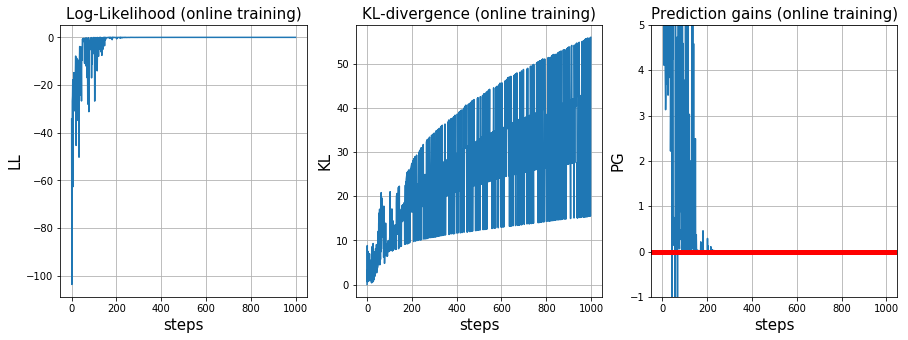

In [103]:
%%time

res = run(0, X_test,
            fc_size=1024, num_layers=2,
            use_adam=False,
            lr=0.0005, momentum=0)

In [105]:
mean_last_ll, rate, all_log_probs, pgs, total_loss_gains, kl_gains = res

In [106]:
mean_last_ll

-6.99464e-05

In [107]:
rate*100

1.9

In [108]:
pgs


array([ 3.43011055e+01,  9.09272385e+01,  3.28291512e+01,  1.54602137e+01,
        9.55811024e+00,  1.21449022e+01,  2.72088509e+01,  4.11192131e+00,
        4.42816925e+00,  5.40221024e+00,  6.76175594e+00,  1.54908371e+01,
        4.25273705e+00,  3.77322960e+00,  3.12995529e+00,  3.42790413e+00,
        5.24898434e+00,  5.93625021e+00,  5.11408329e+00,  9.45070934e+00,
        1.27079315e+01,  4.88909149e+00,  3.68286180e+00,  4.99140358e+00,
        4.33925247e+00,  3.45146942e+00,  3.97379684e+00,  6.16514587e+00,
        3.83592224e+00,  5.19221687e+00,  4.23618078e+00,  6.86125469e+00,
        6.56662273e+00,  1.13376541e+01,  1.37950611e+01,  5.00507545e+00,
        2.21696234e+00,  3.08488655e+00,  2.98403645e+00,  7.90124702e+00,
        4.99389172e+00,  3.33163691e+00,  1.84219623e+00, -6.79387665e+00,
        1.92388859e+01,  4.24179840e+00,  4.69484282e+00,  8.52192593e+00,
        4.43121493e-01,  2.32358873e-01,  7.53117919e-01,  1.39933765e-01,
        3.65514517e-01,  

In [109]:
pgs = np.array(pgs)
total_loss_gains=np.array(total_loss_gains)
kl_gains = np.array(kl_gains)

In [110]:
from collections import defaultdict
n = len(pgs)
cnt = defaultdict(int)

for i in range(n):
    pg_sign = 1 if pgs[i]>=0 else -1
    loss_sign = 1 if total_loss_gains[i]>=0 else -1
    kl_sign = 1 if kl_gains[i] >= 0 else -1
    
    cnt[(pg_sign, loss_sign, kl_sign)] += 1

In [99]:
cnt

defaultdict(int,
            {(-1, -1, -1): 235,
             (-1, 1, -1): 154,
             (-1, 1, 1): 44,
             (1, -1, -1): 174,
             (1, -1, 1): 354,
             (1, 1, 1): 39})

In [100]:
pgs

array([ 3.46714058e+01,  9.28416824e+01,  3.08376350e+01,  1.31002903e+01,
        8.36590195e+00,  7.55911827e+00,  2.40497932e+01,  3.68613243e+00,
        3.83839417e+00,  4.41189957e+00,  4.95695782e+00,  7.56799889e+00,
        7.23660469e+00,  3.38544559e+00,  6.19292831e+00,  5.86939907e+00,
        1.06533127e+01,  3.63854790e+00,  4.01223755e+00,  3.62968159e+00,
        2.78416977e+01,  3.93201160e+00,  2.41703510e+00,  3.36353302e+00,
        1.37805557e+01,  4.84159851e+00,  2.41664696e+00,  4.29181099e+00,
        8.50457573e+00,  4.94766426e+00,  3.22687912e+00,  6.06774139e+00,
        5.93705559e+00,  1.28141708e+01,  9.43423271e+00,  7.18161106e+00,
        4.69750118e+00,  5.06047916e+00,  4.40281630e+00,  6.94107437e+00,
        4.23702621e+00,  4.99318933e+00,  1.93528414e+00,  3.79050922e+00,
        6.64207602e+00,  1.41389060e+00,  2.93833041e+00,  1.32470522e+01,
        3.70255733e+00,  1.49234653e+00,  9.44699526e-01,  5.75163007e-01,
        2.65070915e-01,  

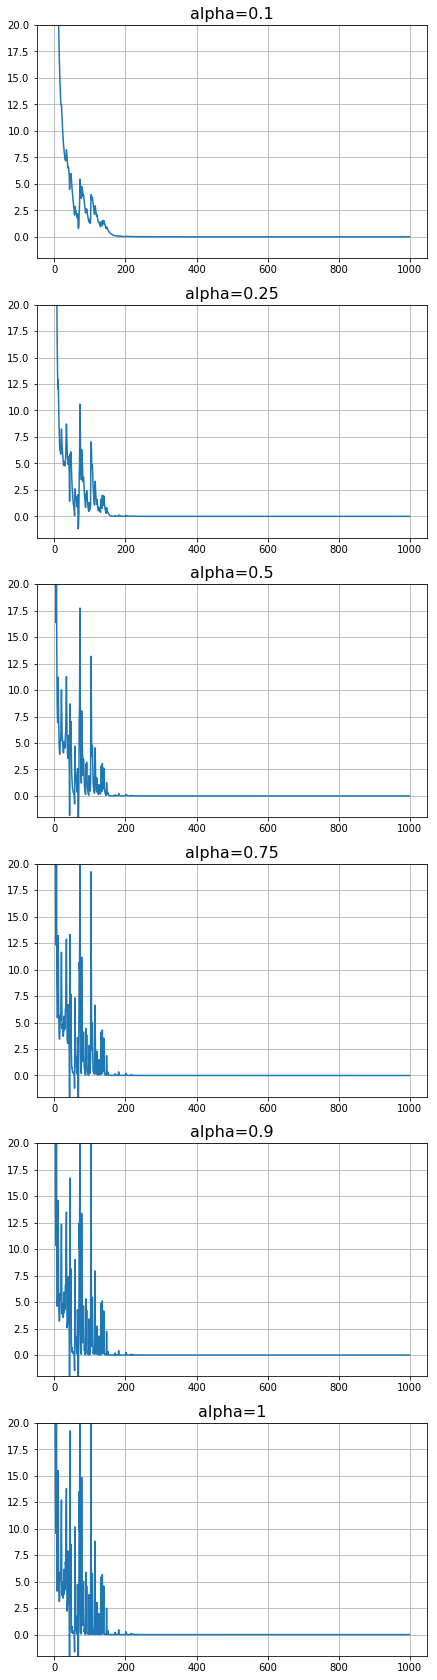

In [111]:
alphas = [0.1, 0.25, 0.5, 0.75, 0.9, 1]

plt.figure(figsize=(7,5*len(alphas)))

for alpha_ind, alpha in enumerate(alphas):
    
    smoothed_pgs = []
    for i, pg in enumerate(pgs):
        if i == 0:
            smoothed_pgs.append(pg)
        else:
            smoothed_pgs.append((1-alpha)*smoothed_pgs[-1] + alpha*pg)
            
    plt.subplot(len(alphas), 1, alpha_ind+1)
    plt.plot(smoothed_pgs)
    plt.grid()
    plt.title('alpha={}'.format(alpha), fontsize=16)
    plt.ylim((-2,20))

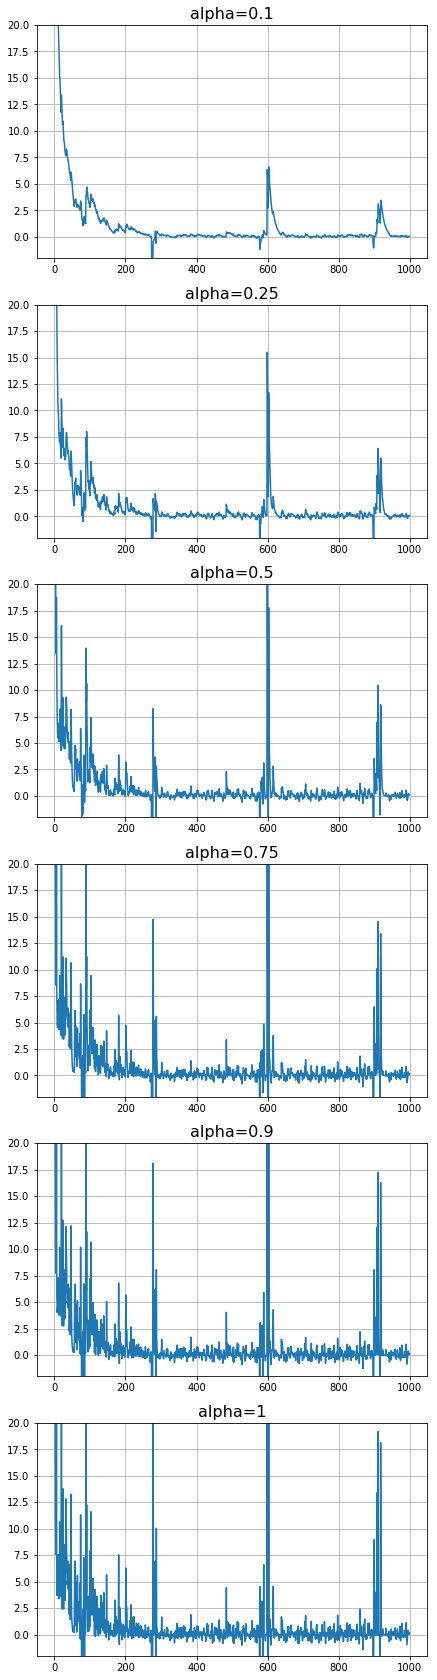

In [102]:
alphas = [0.1, 0.25, 0.5, 0.75, 0.9, 1]

plt.figure(figsize=(7,5*len(alphas)))

for alpha_ind, alpha in enumerate(alphas):
    
    smoothed_pgs = []
    for i, pg in enumerate(pgs):
        if i == 0:
            smoothed_pgs.append(pg)
        else:
            smoothed_pgs.append((1-alpha)*smoothed_pgs[-1] + alpha*pg)
            
    plt.subplot(len(alphas), 1, alpha_ind+1)
    plt.plot(smoothed_pgs)
    plt.grid()
    plt.title('alpha={}'.format(alpha), fontsize=16)
    plt.ylim((-2,20))

In [91]:
pgs[-10:]

array([1.3630750e-05, 1.3269630e-05, 1.5883415e-05, 1.2525823e-05,
       6.6110806e-06, 1.3061508e-05, 1.0650838e-06, 1.5599246e-05,
       3.6951387e-06, 3.0538577e-06], dtype=float32)